In [1]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from matplotlib import pyplot as plt
from matplotlib import patches
import plotly.graph_objects as go
import plotly.express as px

In [2]:
cats = []
adj = []
base_path = '../data/mit_states/release_dataset/'
for fl in (os.listdir(base_path + 'images/')):
    if os.path.isdir(base_path + 'images/' + fl):
        cats.append(fl.split(' ')[1])
        adj.append(fl.split(' ')[0])

print(len(cats))
print(len(adj))

2207
2207


In [3]:
desc_dict = {}
for i in range(len(cats)):
    if cats[i] in desc_dict:
        desc_dict[cats[i]].append(adj[i])
    else:
        desc_dict[cats[i]] = [adj[i]]
print(len(desc_dict.keys()))

245


In [4]:
adj_ants = pd.DataFrame(columns=['adjective', 'antonyms'])
with open(base_path + 'adj_ants.csv') as f:
    for line in f:
        adj = line.split(',')[0].strip()
        ants = line.split(',')[1:]
        ants = [ant.strip() for ant in ants if ant.strip()]
        adj_ants = pd.concat([adj_ants, pd.DataFrame({'adjective': adj, 'antonyms': ants})], ignore_index=True)
adj_ants.head()

,adjective,antonyms
0,ancient,modern
1,barren,verdant
2,bent,straight
3,blunt,sharp
4,bright,dark


In [5]:
# show adjective 'straight' row
adj_ants[adj_ants['adjective'] == 'straight']

,adjective,antonyms
59,straight,winding
60,straight,bent
61,straight,curved


In [6]:
cols = ['category', 'adj', 'image']
df = pd.DataFrame(columns=cols)

In [35]:
# for _dir in os.listdir(base_path + 'images/'):
#     if os.path.isdir(base_path + 'images/' + _dir):
#         for _file in os.listdir(base_path + 'images/' + _dir):
#             if _file.endswith('.jpg'):
#                 df = pd.concat([df, pd.DataFrame([[_dir.split(" ")[1], _dir.split(" ")[0], (base_path + 'images/' + _dir + '/' + _file)]], columns=cols)], ignore_index=True)
# df.head()

In [36]:
# dump the dataframe to a csv file
# df.to_csv(base_path + 'mit_states.csv', index=False)

In [37]:
# load dataset
df = pd.read_csv(base_path + 'mit_states.csv')
print(len(df))
df.head()

63440


,category,adj,image
0,elephant,old,../data/mit_states/release_dataset/images/old ...
1,elephant,old,../data/mit_states/release_dataset/images/old ...
2,elephant,old,../data/mit_states/release_dataset/images/old ...
3,elephant,old,../data/mit_states/release_dataset/images/old ...
4,elephant,old,../data/mit_states/release_dataset/images/old ...


(256, 256, 3)


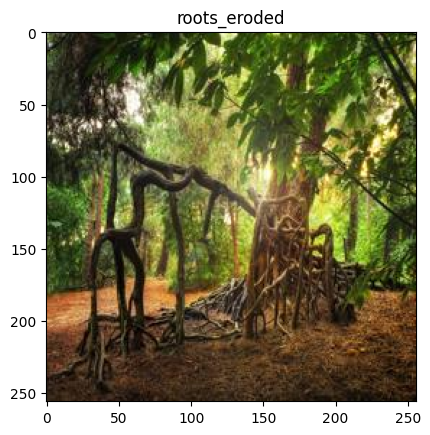

In [38]:
idx = random.randint(0, len(df))
# show a random image with its category and adjective
img = plt.imread(df['image'][idx])
print(img.shape)
plt.imshow(img)
plt.title(df['category'][idx] + '_' + df['adj'][idx])
plt.show()

In [39]:
# /home/smbh/.cache/torch/hub/checkpoints/
# https://pytorch.org/vision/stable/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html#fasterrcnn-resnet50-fpn

# FasterRCNN RESNET50 Feature Extractor
class FasterRCNNFeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FasterRCNNFeatureExtractor, self).__init__()
        self.model = model
        self.model.eval()
        self.model.roi_heads = nn.Identity()

    def forward(self, x):
        return self.model(x)

In [40]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [ ]:
model = fasterrcnn_resnet50_fpn(
    weights='DEFAULT',
    num_classes=91,
    weights_backbone='DEFAULT',
    trainable_backbone_layers=0,
)
# model = FasterRCNNFeatureExtractor(model)
model.to(device)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

(256, 256, 3)


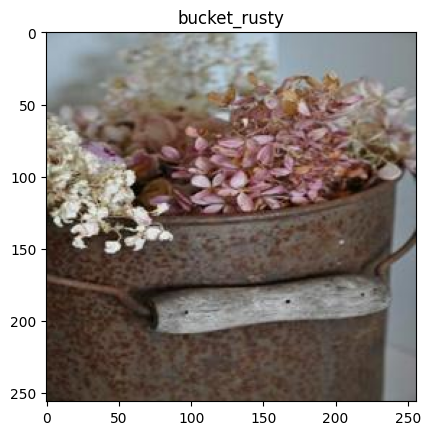

In [ ]:
idx = random.randint(0, len(df))
img = plt.imread(df['image'][idx])
cat = df['category'][idx]
adj = df['adj'][idx]
img = img / 255.0
print(img.shape)
plt.imshow(img)
plt.title(df['category'][idx] + '_' + df['adj'][idx])
plt.show()

In [ ]:
# For inference
# x = [torch.rand(3, 300, 400).cuda(), torch.rand(3, 500, 400).cuda()]
# x = [torch.rand(3, 300, 400).to(device), torch.rand(3, 500, 400).to(device)]
x = [torch.from_numpy(img).permute(2, 0, 1).float().to(device),]
preds = model(x)
preds

[{'boxes': tensor([[  0.0000,  24.8862, 256.0000, 256.0000],
          [  7.1655,  20.5352, 253.8336, 168.7225],
          [  3.5776,  28.2492, 243.7144, 156.7137],
          [  0.0000,  23.4410, 254.7959, 245.9565],
          [ 32.3239, 171.3287, 247.6966, 219.2393],
          [ 62.2990,  40.1741, 246.4590, 125.9415],
          [  0.9616,  22.4284, 249.6024, 190.9553]], device='cuda:1',
         grad_fn=<StackBackward0>),
  'labels': tensor([67, 59, 61, 79, 49, 59, 51], device='cuda:1'),
  'scores': tensor([0.5079, 0.3369, 0.2074, 0.1677, 0.1497, 0.1176, 0.0869],
         device='cuda:1', grad_fn=<IndexBackward0>)}]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


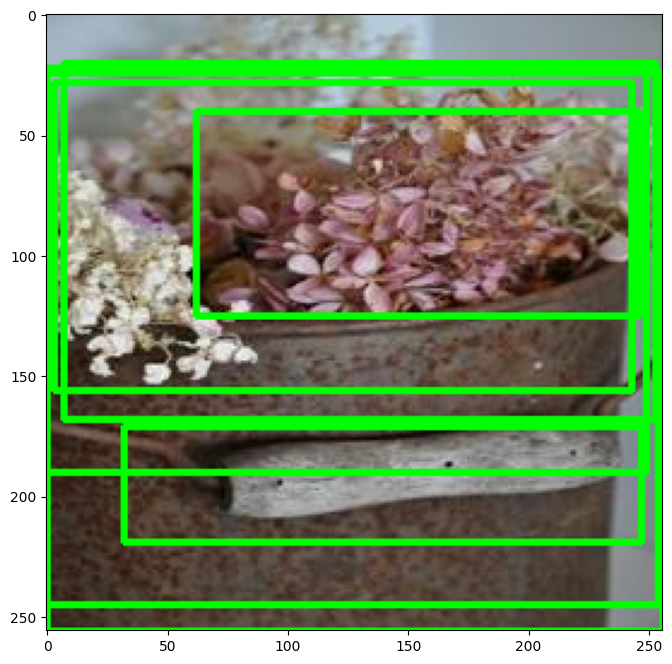

In [ ]:
# show x[0] with bounding boxes
img_with_boxes = x[0].permute(1, 2, 0).cpu().numpy()
fig, ax = plt.subplots(1, figsize=(16, 8))
for box in preds[0]['boxes']:
    box = box.cpu().detach().numpy().astype(np.int32)
    cv2.rectangle(img_with_boxes, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
ax.imshow(img_with_boxes)
plt.show()

In [ ]:
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
# dict of labels
labels = {i: weights.meta["categories"][i] for i in range(1, 91)}
labels

{1: 'person',
 2: 'bicycle',
 3: 'car',
 4: 'motorcycle',
 5: 'airplane',
 6: 'bus',
 7: 'train',
 8: 'truck',
 9: 'boat',
 10: 'traffic light',
 11: 'fire hydrant',
 12: 'N/A',
 13: 'stop sign',
 14: 'parking meter',
 15: 'bench',
 16: 'bird',
 17: 'cat',
 18: 'dog',
 19: 'horse',
 20: 'sheep',
 21: 'cow',
 22: 'elephant',
 23: 'bear',
 24: 'zebra',
 25: 'giraffe',
 26: 'N/A',
 27: 'backpack',
 28: 'umbrella',
 29: 'N/A',
 30: 'N/A',
 31: 'handbag',
 32: 'tie',
 33: 'suitcase',
 34: 'frisbee',
 35: 'skis',
 36: 'snowboard',
 37: 'sports ball',
 38: 'kite',
 39: 'baseball bat',
 40: 'baseball glove',
 41: 'skateboard',
 42: 'surfboard',
 43: 'tennis racket',
 44: 'bottle',
 45: 'N/A',
 46: 'wine glass',
 47: 'cup',
 48: 'fork',
 49: 'knife',
 50: 'spoon',
 51: 'bowl',
 52: 'banana',
 53: 'apple',
 54: 'sandwich',
 55: 'orange',
 56: 'broccoli',
 57: 'carrot',
 58: 'hot dog',
 59: 'pizza',
 60: 'donut',
 61: 'cake',
 62: 'chair',
 63: 'couch',
 64: 'potted plant',
 65: 'bed',
 66: 'N/A'

In [ ]:
for i in range(len(preds[0]["labels"])):
    lbl = preds[0]["labels"][i].item()
    tag = labels.get(lbl)
    score = preds[0]["scores"][i].item()
    print(lbl, tag, score)

67 dining table 0.5079311728477478
59 pizza 0.33694687485694885
61 cake 0.20742268860340118
79 oven 0.16767656803131104
49 knife 0.1497272551059723
59 pizza 0.11763878911733627
51 bowl 0.08694881945848465


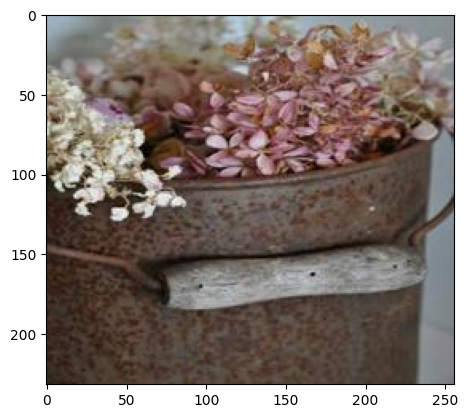

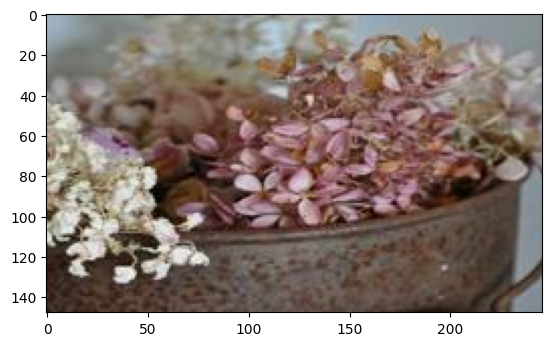

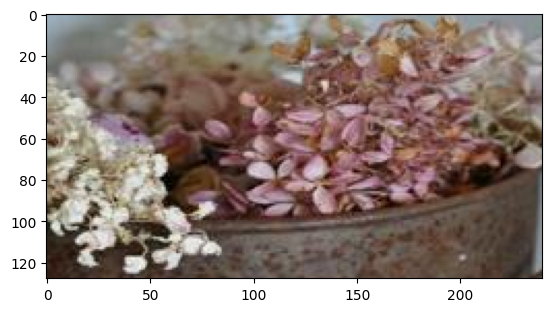

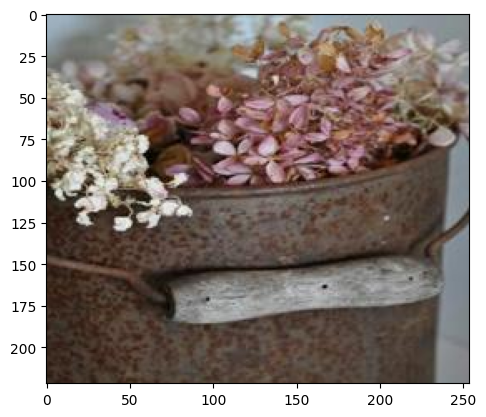

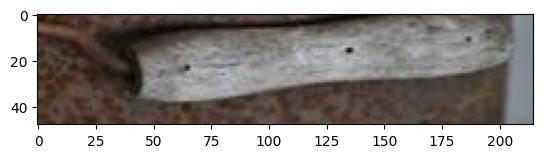

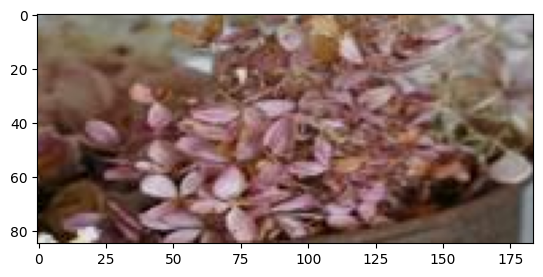

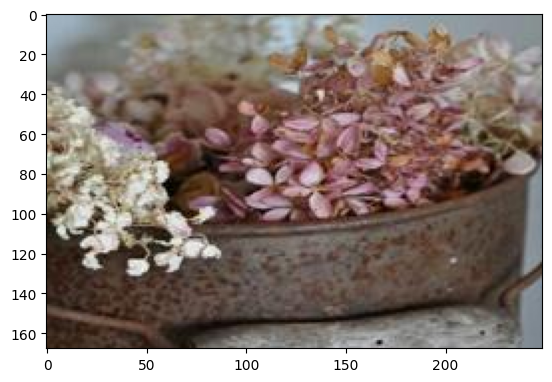

In [ ]:
# crop the image with bounding boxes
for box in preds[0]['boxes']:
    box = box.cpu().detach().numpy().astype(np.int32)
    crop = img[box[1]:box[3], box[0]:box[2]]
    plt.imshow(crop)
    plt.show()

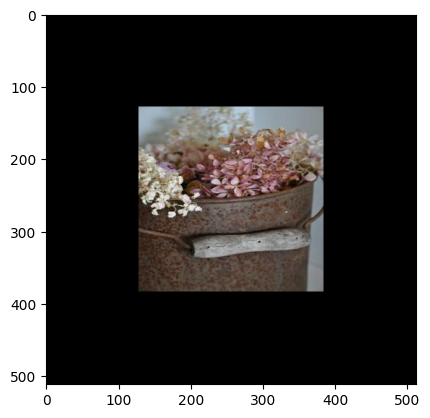

In [ ]:
new_shape = (512, 512)
# padding image to new shape (put the original image at the center of the new image)
new_img = np.zeros((new_shape[0], new_shape[1], 3))
new_img[
    (new_shape[0] - img.shape[0]) // 2 : (new_shape[0] - img.shape[0]) // 2 + img.shape[0],
    (new_shape[1] - img.shape[1]) // 2 : (new_shape[1] - img.shape[1]) // 2 + img.shape[1],
    :
] = img
plt.imshow(new_img)

In [ ]:
# add boxes col to df
df['boxes'] = None
print(df.head())

   category  adj                                              image boxes
0  elephant  old  ../data/mit_states/release_dataset/images/old ...  None
1  elephant  old  ../data/mit_states/release_dataset/images/old ...  None
2  elephant  old  ../data/mit_states/release_dataset/images/old ...  None
3  elephant  old  ../data/mit_states/release_dataset/images/old ...  None
4  elephant  old  ../data/mit_states/release_dataset/images/old ...  None


In [ ]:
max_boxed_size = (0, 0)
err = 0
# go through all the images and crop them
for idx in range(len(df)):
    img = plt.imread(df['image'][idx])
    cat = df['category'][idx]
    adj = df['adj'][idx]
    img = img / 255.0
    try:
        x = [torch.from_numpy(img).permute(2, 0, 1).float().to(device),]
    except Exception as e:
        print(e)
        print(f"{idx}. {cat} {adj} - {img.shape}")
        print(img.shape)
        err += 1
        continue
    preds = model(x)
    this_boxes = []
    for box in preds[0]['boxes']:
        box = box.cpu().detach().numpy().astype(np.int32)
        crop = img[box[1]:box[3], box[0]:box[2]]
        # cv2.imwrite(base_path + 'images/' + cat + '_' + adj + '/' + str(idx) + '.jpg', crop)
        this_boxes.append(crop)
        # check crop size
        if crop.shape[0] > max_boxed_size[0] or crop.shape[1] > max_boxed_size[1]:
            max_boxed_size = crop.shape
    df['boxes'][idx] = this_boxes
print(f"Total errors: {err}")

Total errors: 0


(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)
(253, 233, 3)


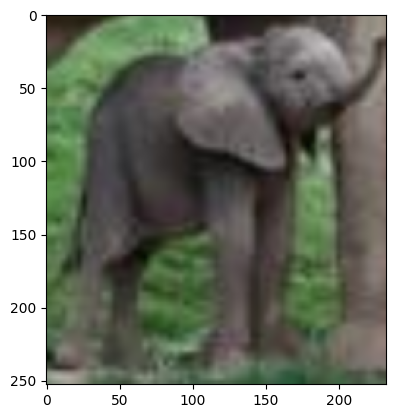

In [ ]:
print(max_boxed_size)
# padding all boxes to max_boxed_size
for idx in range(len(df)):
    this_boxes = df['boxes'][idx]
    if this_boxes is None:
        continue
    paded_boxes = []
    for i in range(len(this_boxes)):
        print(this_boxes[i].shape)
        # # padding image to new shape (put the original image at the center of the new image)
        # new_img = np.zeros((max_boxed_size[0], max_boxed_size[1], 3))
        # new_img[
        #     (max_boxed_size[0] - img.shape[0]) // 2 : (max_boxed_size[0] - img.shape[0]) // 2 + img.shape[0],
        #     (max_boxed_size[1] - img.shape[1]) // 2 : (max_boxed_size[1] - img.shape[1]) // 2 + img.shape[1],
        #     :
        # ] = img
        new_img = cv2.resize(this_boxes[i], (max_boxed_size[1], max_boxed_size[0]))
        # plt.imshow(new_img)
        paded_boxes.append(new_img)
    df['boxes'][idx] = paded_boxes

In [ ]:
# dump df
# df.to_csv("boxed.csv", index=False)